**Forecasting future value of APPLE Stock Using Time Series Analysis - ARIMA**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
%matplotlib inline
import quandl

Lets collect data of APPLE Stock for 8 years to forecast future value of the stock using time series analysis. 

In [33]:
APPLE = quandl.get("YAHOO/AAPL")
APPLE.to_csv('APPLE.csv')
lastAPPLE = APPLE[-1:]
APPLE = APPLE[:-1]
APPLE.head()

,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
1980-12-12,28.750000,28.875000,28.750,28.750,117258400.0,0.423253
1980-12-15,27.375001,27.375001,27.250,27.250,43971200.0,0.401170
1980-12-16,25.375000,25.375000,25.250,25.250,26432000.0,0.371726
1980-12-17,25.875000,25.999999,25.875,25.875,21610400.0,0.380927
1980-12-18,26.625000,26.750000,26.625,26.625,18362400.0,0.391969


In [35]:
# Lets take Log of the daily the closing value to ensures that level induced volatility does not interfere with the stationarity of series.

APPLE['date']= APPLE.index
APPLE['APPLE']= APPLE.Close
APPLE['logAPPLE']= np.log(APPLE['APPLE'])
APPLE['diflogAPPLE'] = APPLE['logAPPLE'] - APPLE['logAPPLE'].shift(periods=-1)
APPLE = APPLE.dropna()

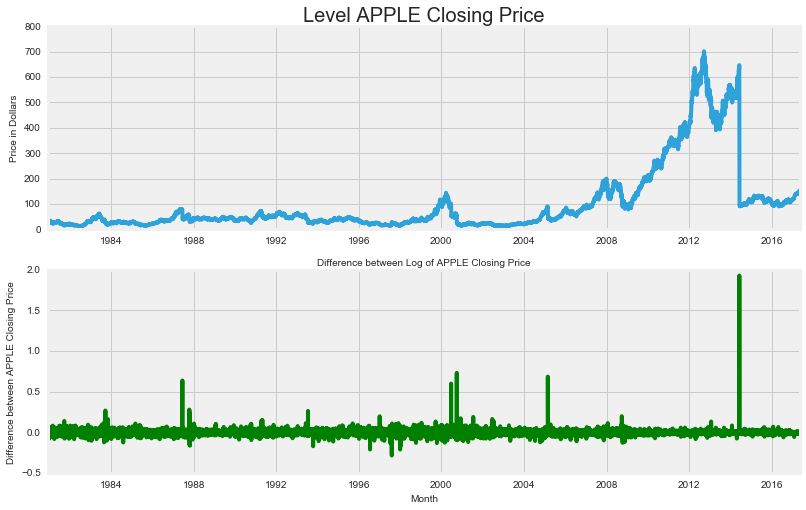

In [37]:
# As we are interested in the day to day change of the stock prices, we take the difference of the closing values. This differencing is another way to get the time series to be stationary.

fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(APPLE.date, APPLE.APPLE, label = "Log of APPLE Closing Price")
plt.title("Level APPLE Closing Price", size = 20,)
plt.ylabel("Price in Dollars", size = 10)

plt.subplot(2, 1, 2)
plt.plot(APPLE.date, APPLE.diflogAPPLE, label = '1st Diffrence of Log of APPLE', color = 'g')
plt.title("Difference between Log of APPLE Closing Price", size = 10,)
plt.ylabel("Difference between APPLE Closing Price", size = 10)
plt.xlabel('Month', size = 10)

For reliable forecasting, we need Stationarity series. Therefore performing Dickey-Fuller test to test whether the series is Stationary or not. The smaller the value of p, the more the series is stationary. 

In [42]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(APPLE.diflogAPPLE, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -47.918946
p-value                           0.000000
# Lags Used                       3.000000
Number of Observations Used    9177.000000
Critical Value (5%)              -2.861855
Critical Value (1%)              -3.431063
Critical Value (10%)             -2.566938
dtype: float64


Let's implement Time series analysis model: ARIMA (Auto-Regressive-Integrated-Moving-Average). 

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors.  That is:

Predicted value of Y = a constant and/or a weighted sum of one or more recent values of Y and/or a weighted sum of one or more recent values of the errors.

In [50]:
ararray = (APPLE.logAPPLE.dropna().as_matrix())
p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
            
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print ("Best Model is :", (p,d,q))
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

(0, 1, 0) -34085.2599452
(0, 1, 1) -34086.234222330095
(0, 1, 2) -34086.590955836626
(1, 1, 0) -34086.13435339517
(1, 1, 1) -34084.91057838261
(2, 1, 0) -34086.87964373149
(2, 1, 1) -34085.87300912154
Best Model is : (2, 1, 0)


In [58]:
numofsteps = 1
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors
print ('%s Steps Ahead Forecast Value is:' % numofsteps, np.exp(stepahead))
print ('%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0]))
print ('April 26th 2016 Close (most recent): %s ' % lastAPPLE.Close)

1 Steps Ahead Forecast Value is: [ 153.2581724]
1 Steps Ahead 95 percent CI is: [ 142.33025315  165.02512212]
April 26th 2016 Close (most recent): Date
2017-05-12    156.100006
Name: Close, dtype: float64 
